# Time Series Classification and Clustering Assignment

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import classification_report as cr
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [3]:
WMT = 'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv'
data = pd.read_csv(WMT)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [4]:
data['date'] = pd.to_datetime(data['date'])

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [8]:
data['returns'] = data['close'].pct_change()
data['MA_5'] = data['close'].rolling(5).mean()
data['MA_10'] = data['close'].rolling(10).mean()
    
data['trend'] = 'None'
data.loc[(data['MA_5'] < data['MA_10']), 'trend'] = 'Negative'
data.loc[(data['MA_5'] > data['MA_10']), 'trend'] = 'Positive'
data['change'] = data['trend'].eq(data['trend'].shift())

data['binary'] = 0
data.loc[(data['change']==False) & (data['trend']!='None'), 'binary'] = 1

data.dropna(inplace=True)
#data.drop(data.index[0], inplace=True)

In [10]:
transformed = data[['date','returns','binary']]
history = 180
future = 0

shifts = [x + future for x in range(1, history + 1)]

for shift in shifts:
  transformed['t-' + str(shift)] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
transformed.head()

,date,returns,binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
189,2013-11-07,-0.008316,0,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,...,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993
190,2013-11-08,0.005806,0,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,...,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568
191,2013-11-11,0.013468,0,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,...,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512
192,2013-11-12,-0.003797,0,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,...,-0.013402,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734
193,2013-11-13,0.002414,0,-0.003797,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,...,0.007946,-0.013402,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493

In [20]:
x = transformed.drop(['date','returns','binary'], axis=1)
y = transformed['binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=False)


In [49]:
y_train.value_counts()

0    750
1    106
Name: binary, dtype: int64

### Train a Logistic Regression classification model on the transformed data.

In [50]:
model = LR(class_weight='balanced')
model.fit(x_train, y_train)
preds = model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [51]:
print(cr(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78       195
           1       0.08      0.26      0.12        19

    accuracy                           0.65       214
   macro avg       0.49      0.48      0.45       214
weighted avg       0.83      0.65      0.72       214



### Transform the data again to have 10 days of history for clustering.

In [30]:
transformed1 = data[['date','returns','binary']]
history1 = 10
#future = 0

shifts1 = [x + future for x in range(1, history1 + 1)]

for shift in shifts1:
  transformed1['t-' + str(shift)] = transformed1['returns'].shift(shift)

transformed1.dropna(inplace=True)
transformed1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,returns,binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
19,2013-03-08,-0.003955,0,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993
20,2013-03-11,-0.000685,0,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568
21,2013-03-12,0.008495,0,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512
22,2013-03-13,0.000679,0,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734
23,2013-03-14,-0.005838,0,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280


In [31]:
x = transformed1.drop(['date','returns','binary'], axis = 1)

### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [24]:
def kmeans (df, clusters=2):
  model = KMeans(n_clusters=clusters)
  cluster = model.fit_predict(df)
  results = df.copy()
  results['cluster'] = cluster

  cluster_size = results.groupby(['cluster']).size().reset_index()
  cluster_size.columns = ['cluster', 'count']
  cluster_means = results.groupby(['cluster'], as_index=False).mean()
  summary = pd.merge(cluster_size, cluster_means, on='cluster')

  return results, summary


In [48]:
res2, sum2 = kmeans(x, clusters=2)
print(sum2)
res3, sum3 = kmeans(x, clusters=3)
print(sum3)
res4, sum4 = kmeans(x, clusters=4)
print(sum4)
res5, sum5 = kmeans(x, clusters=5)
print(sum5)
res6, sum6 = kmeans(x, clusters=6)
print(sum6)
res7, sum7 = kmeans(x, clusters=7)
print(sum7)

   cluster  count       t-1       t-2  ...       t-7       t-8       t-9      t-10
0        0    601 -0.002769  0.001838  ... -0.002721  0.003353  0.003476 -0.000950
1        1    639  0.003217 -0.001135  ...  0.003349 -0.002365 -0.002507  0.001647

[2 rows x 12 columns]
   cluster  count       t-1       t-2  ...       t-7       t-8       t-9      t-10
0        0    414 -0.005171  0.000166  ...  0.001528 -0.003835 -0.001489  0.005359
1        1    426  0.004173 -0.004955  ... -0.003580  0.001259  0.003933  0.000069
2        2    400  0.001888  0.006053  ...  0.003494  0.003888 -0.001429 -0.004415

[3 rows x 12 columns]
   cluster  count       t-1       t-2  ...       t-7       t-8       t-9      t-10
0        0    283  0.004707  0.004252  ...  0.004811 -0.000344 -0.005808  0.000367
1        1    315 -0.003364  0.000002  ...  0.003494 -0.004633  0.002041  0.007123
2        2    304 -0.002835  0.003348  ... -0.000843  0.006498 -0.001329 -0.004114
3        3    338  0.002903 -0.005450  ..

### Visualize the summary of the clustering results as a heatmap.

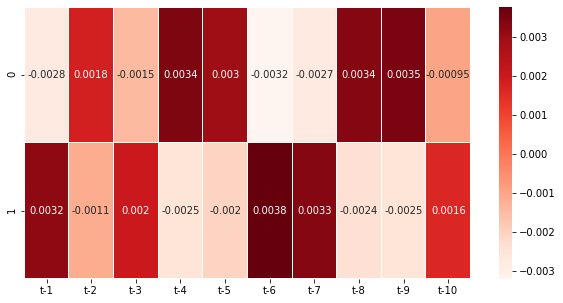

In [56]:
plt.figure(figsize=(10,5))
sns.heatmap(sum2.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)

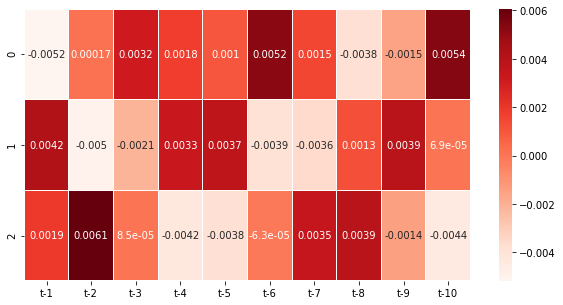

In [58]:
plt.figure(figsize=(10,5))
sns.heatmap(sum3.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)

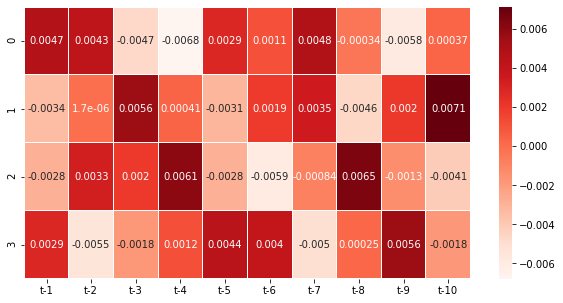

In [59]:
plt.figure(figsize=(10,5))
sns.heatmap(sum4.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)

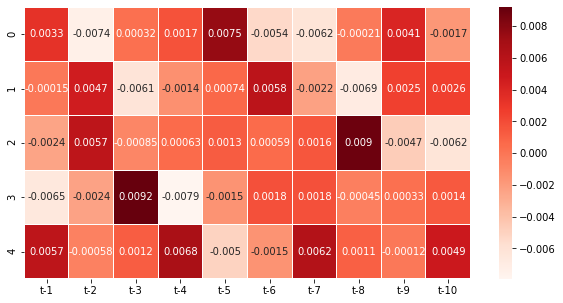

In [60]:
plt.figure(figsize=(10,5))
sns.heatmap(sum5.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)

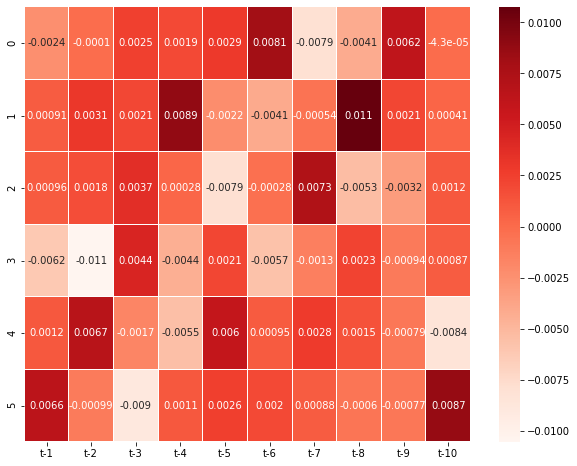

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(sum6.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)

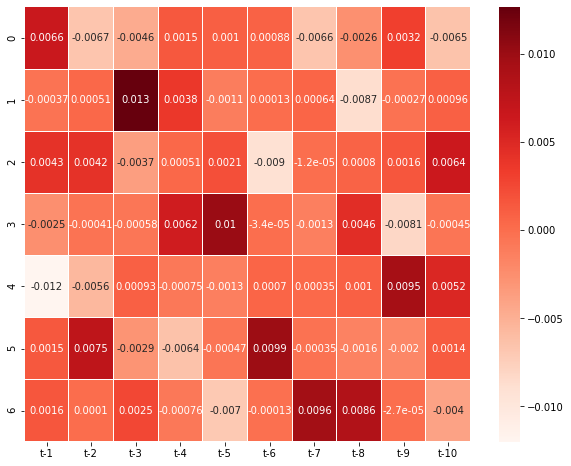

In [62]:
plt.figure(figsize=(10,8))
sns.heatmap(sum7.drop(columns=['cluster', 'count']), cmap='Reds', linewidths=0.01, annot=True)